# Task specific functions

The classes and functions in this notebook are highly specific and probably not usefull for the most tasks.


In [ ]:
# hide
import sys
sys.path.append("..")

In [ ]:
# export
# default_exp utils

from fastai.basics import *
import pathlib
import SimpleITK as sitk

In [ ]:
from fastai.vision.all import *

In [ ]:
m = resnet50(pretrained = True)

def return_model(*args, **kwargs):
    return m

dls.c = 4
learn = unet_learner(dls, return_model, loss_func=nn.BCELoss)
torch.mean((list(learn.model.parameters())[0] ==list(m.parameters())[0]).float())

tensor(1.)

In [ ]:
# export

from faimed3d.basics import *
from faimed3d.augment import *
from faimed3d.data import *
from faimed3d.models.unet import *
from faimed3d.models.resnet import *
from faimed3d.models.losses import *

## Flipping NIfTI images
When displaying the masks it may occure, that Nifti images are rotated and do not fit the original DICOM. Most likely it is due to different frames of reference. 
in Simple-ITK it is LPS, while NIfTI and FSL use RAS, so those matrices are the same after accounting for frame of reference (taken and adapted from https://discourse.itk.org/t/nifti-orientation-issues/431).
So, luckly the malrotations are systematic and can be scripted.

In [ ]:
# export utils
class RotateNifti():
    def __init__(self):
        warn('This class will change the source files on you disk. Be carefull.')
    
    def rotate_single(self, fn:(Path, str)):
        if isinstance(fn, Path): fn = str(fn) 
        
        im = sitk.ReadImage(fn)
        arr = sitk.GetArrayFromImage(im)
        arr = np.rot90(arr, 0)
        arr = np.flip(arr, 1)
        im2 = sitk.GetImageFromArray(arr)
        for k in im.GetMetaDataKeys(): # Copy meta data from original image before overwriting it. 
            im2.SetMetaData(k, im.GetMetaData(k))
        sitk.WriteImage(im2, fn)
   
    def rotate_list(self, file_list=None, verbose = True):
        if file_list is not None: self.file_list = file_list
    
        for fn in file_list: 
            self.rotate_single(fn)
            if verbose: print('converted file at: '+str(fn))

In [ ]:
r = RotateNifti()

/home/bressekk/anaconda3/envs/fastai-v2/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: This class will change the source files on you disk. Be carefull.
  after removing the cwd from sys.path.


## Exporting subvolumes

In processing medical 3D data, a challenge is to that the regions of interest are often very small. For example, if the goal is to segment and classify kideny cancer from abdominal CT scans, the cancer corresponds to less then 1% of the voxels in the volume. The most voxels are not relevant for the task. One possibility to deal with this problem, is to first train a model which segments the whole kidney and to only export this subvolume. Then a second model can be trained on the subvolumes. 


At first a learner must be created, so that predictions can be made

In [ ]:
d = pd.read_csv('../../dl-prostate-mapping/data/full_data.csv')
d = d[['t2_dcm_path', "t2_mask_base", "is_valid"]]

In [ ]:
# design dataloader
mris = DataBlock(
    blocks = (ImageBlock3D(cls=TensorDicom3D), 
              MaskBlock3D(cls=TensorMask3D)),
    get_x = lambda x: x[0],
    get_y = lambda x: x[1], 
    item_tfms = ResizeCrop3D(crop_by = (0.2, 0.15, 0.15), resize_to = (16, 100, 100), perc_crop = True),
    batch_tfms = [
        *aug_transforms_3d(p_all=0.25, do_rotate_by = False), 
        RandomCrop3D(((0, 0), (0,0), (0,0)), (0, 0, 0)), 
        ClampMask3D,
        PseudoColor],
    splitter = ColSplitter())

# construct dataloader
dls = mris.dataloaders(d, 
                       batch_size = 10, 
                       num_workers = 0,
                      )

# creater learner
learn = Learner(dls, 
                UNet3D(n_channels = 1, n_classes = 2),
                opt_func = SGD, 
                loss_func = MCCLossBinary(), 
                model_dir = '../pretrained/',
               )
learn = learn.to_fp16()
learn = learn.load('unet-whole-prostate-20x100x100')

NameError: name 'UNet3D' is not defined

To convieniently perform predictions, cropping and exporting a `SubvolumeExporter` class is created.

In [ ]:
# export
class SubvolumeExporter(object):
    def __init__(self):
        self.model = None
        self.item_tfms = None
    
    def assign_model(self, model):
        self.model = model
        
    def assign_tfms(self, tfms):
        "assign transformations which should be applied to the surce, before size of source and mask are matched"
        self.item_tfms = tfms
    
    def merge_mask(self, mask):
        mask = mask.squeeze()
        if mask.ndim == 4:
            mult_channel_by = tensor(range(0, mask.size(0)))
            mask = mask * mult_channel_by[:, None, None, None]
            return torch.sum(mask, 0)  
        else: return mask
        
    def match_size_mask_source(self):
        "rescales the segmentation mask to the original image resolution"

        if self.item_tfms == None: raise TypeError('No item_tfms specified.')
        source = TensorDicom3D.create(self.item_path)
        self.metadata = source.metadata
        source = self.item_tfms(source) # will lose metadata in transforms
        
        x,y = source.size()[1:]
        z = self.mask.size(0)
        source = source.resize_3d(size = (z,x,y), mode = 'trilinear')
        self.mask = self.mask.resize_3d(size = source.size(), mode = 'nearest')
        self.mask = TensorMask3D(self.mask)
        self.orig = TensorMask3D(source)
        self.mask.metadata = self.metadata
        self.orig.metadata = self.metadata

    
    def predict(self, item, rm_type_tfms=None):
        self.item_path = item
        _, self.mask, _ = self.model.predict(self.item_path, rm_type_tfms)
        self.mask = self.mask.round()
        self.mask = self.merge_mask(self.mask)
        self.mask = TensorMask3D(self.mask)

        self.match_size_mask_source()
    
    def show_pair(self, alpha = 0.25, **kwargs):
        self.orig.show(**kwargs)
        self.mask.show(add_to_existing = True, alpha = alpha, cmap = 'jet', **kwargs)
        
    def strip_pair(self, pad_z = 1, pad_xy = 5):
        "padds the idexes, so that a small margin of zeros remains"

        self.orig.strip_idx = self.mask.get_strip_idx(symmetric=True)
        self.mask = self.mask.strip(pad_z = pad_z, pad_xy=pad_xy)
        self.orig = self.orig.strip(pad_z = pad_z, pad_xy=pad_xy)
        self.orig.metadata = self.metadata
        self.mask.metadata = self.metadata
        
    def convert_and_export(self, source, orig_name, mask_name, pad_z, pad_xy, verbose):
        """
        Reads a list of source images and uses a given learner to predict the mask. Crops the mask and source image an then exports the files. 
        
        Args: 
            source: str or path. The path to the original image. Can be a DICOM direcetory or a single DICOM, NIfTI, NRRD, Analyze file (any type supported by SimpleITK) 
            orig_name: str or path. New filename for the cropped original image
            mask_name: str or path. New filename for the predicted mask.
            
        returns: 
            Nothing. Writes files to disk.
        """
        if self.model is None: raise NameError('No model for predictions assigned. Assing a model to the {} using {}.assign_model(model)'.format(self.__class__.__name__, self.__class__.__name__))
        
        self.predict(source)
        self.strip_pair(pad_z = pad_z, pad_xy = pad_xy)
        self.orig.save(orig_name)
        self.mask.save(mask_name)
        
        if verbose: print('wrote image to {} and mask to {}'.format(str(orig_name), str(mask_name)))
            
    def convert_and_export_list(self, source, orig_name, mask_name, pad_z = 1, pad_xy = 5, verbose = True):
        if not isinstance(source, list) or not isinstance(orig_name, list) or not isinstance(mask_name, list): raise TypeError('source, orig_name, mask_name need to be lists of equal size')
        if len(source) != len(orig_name) or len(source) != len(mask_name): raise TypeError('source, orig_name, mask_name need to be lists of equal size')
                     
        for s, o, m, in zip(source, orig_name, mask_name): 
            self.convert_and_export(s, o, m, pad_z, pad_xy, verbose)            

A model needs to be assigned to the SubvolumeExporter, so predictions on new data can be made. 

In [ ]:
SubvolumeExport = SubvolumeExporter() 
SubvolumeExport.assign_model(learn)
SubvolumeExport.assign_tfms(RandomCrop3D(crop_by = (0.2, 0.15, 0.15), rand_crop_xyz = (0,0,0), perc_crop = True))
SubvolumeExport.predict(d.t2_dcm_path[0]) # predict mask on one image

To check the quality of the class and predictions, botch can be visualized.  

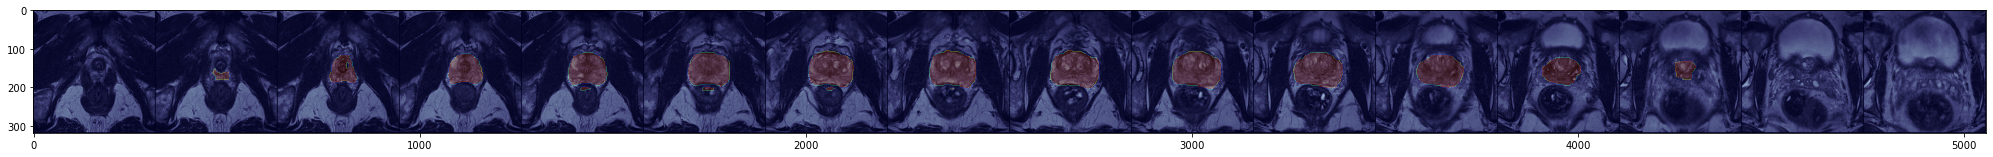

In [ ]:
SubvolumeExport.show_pair(nrow = 16, figsize = (35, 25))

Using strip_paor reduces the image size, so that it narrowly fits the mask. 
Per default padding will be 0 so the largest mask diameter will decide on the size of the image. Using pad_z, pad_x, pad_y (or pad_xy instead of pad_x, pad_y) a small marign can be added in case the classes do not fit perfectly. Padding image size larger then original size is not possible and will not lead to black spaces.  

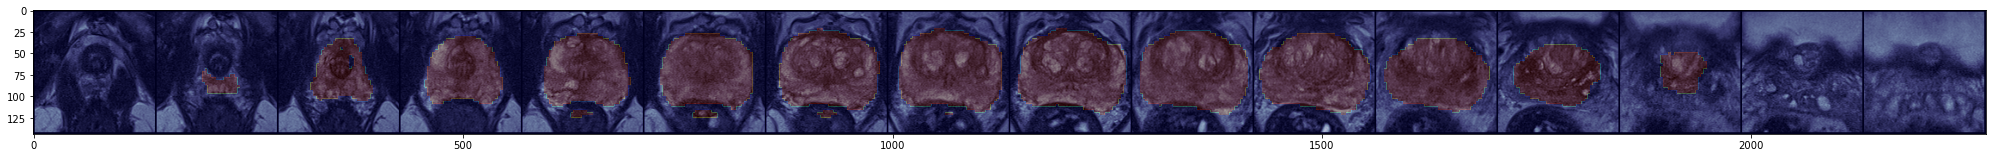

In [ ]:
SubvolumeExport.strip_pair(pad_xy = 5, pad_z = 10)
SubvolumeExport.show_pair(nrow = 16, figsize = (35, 25))

In [ ]:
SubvolumeExport.mask.calc_volume()

{'background': 108573.6640625, 'total_mask_volume': 43301.33047978772, 'class 1': 43301.32421875}


## Reduce size of original image and mask

The predicted mask and theroff derived images can be used for segementation pipelines, however the mask shows only as much imformation as the model did predict. To further train the images, it makes no sense exporting the predicted mask, but the original mask and images need to be cropped and exported. A subclass of `SubvolumeExporter` can convert the original files, but the export functions need to be adapted.  

In [ ]:
# export
class CropOriginalToMask(SubvolumeExporter):
    
    def load_pair(self, image, mask):
        self.orig = TensorMask3D.create(image)
        self.mask = TensorMask3D.create(mask)
        self.metadata = self.orig.metadata
        
        self.mask.metadata = self.metadata
        
    def export_pair(self, new_image, new_mask, pad_z, pad_xy):
        self.strip_pair(pad_z = pad_z, pad_xy = pad_xy)
        self.orig.save(new_image)
        self.mask.save(new_mask)
        
    def convert_and_export(self, image, mask, new_image=None, new_mask=None, pad_z=1, pad_xy=10, verbose = True):
        if isinstance(image, str): image = Path(image)
        if isinstance(mask, str): mask = Path(mask)
                
        if new_image is None: 
            if image.is_dir(): 
                new_image = image/'cropped_volume.nii.gz'
            else: 
                new_image = image.parent/'cropped_volume.nii.gz'
                
                
        if new_mask is None: 
            if mask.is_dir(): 
                new_mask = mask/'cropped_mask.nii.gz'
            else:     
                new_mask = mask.parent/'cropped_mask.nii.gz'
          
        self.load_pair(image, mask)
        self.export_pair(new_image, new_mask, pad_z, pad_xy)
               
        if verbose: print('wrote image to {} and mask to {}'.format(str(new_image), str(new_mask)))
            
    def convert_and_export_list(self, image, mask, new_image=None, new_mask=None,  pad_z = 1, pad_xy = 10, verbose = True):
        if not isinstance(image, list) or not isinstance(mask, list): raise TypeError('source, orig_name, mask_name need to be lists of equal size')
         
        if len(image) != len(mask): raise TypeError('source, orig_name, mask_name need to be lists of equal size')
        
        if new_image is None: new_image = [None for i in image]
        if new_mask is None: new_mask = [None for i in mask]
            
        
        for i, m, ni, nm in zip(image, mask, new_image, new_mask): 
            self.convert_and_export(image=i, mask=m, new_image=ni, new_mask=nm, pad_z=pad_z, pad_xy=pad_xy, verbose=verbose)    

In [ ]:
Crop = CropOriginalToMask()

In [ ]:
Crop.convert_and_export(d.t2_dcm_path[0], d.t2_mask_base[0])

wrote image to /media/ScaleOut/prostata/data/dcm/A0041430681/T2/DICOM/cropped_volume.nii.gz and mask to /media/ScaleOut/prostata/data/dcm/A0041430681/T2/Annotation/cropped_mask.nii.gz


In [ ]:
# hide
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_basics.ipynb.
Converted 02_transforms.ipynb.
Converted 03_datablock.ipynb.
Converted 04_datasets.ipynb.
Converted 05a_models.modules.ipynb.
Converted 05b_models.cnn.ipynb.
Converted 05c_models.unet.ipynb.
Converted 05d_models.losses.ipynb.
Converted 06_callback.ipynb.
Converted 99_tools.ipynb.
Converted index.ipynb.
